
=== Running attack rate: 0% ===
  Training fedavg...
  Training fedavg_m...
  Training median...

=== Running attack rate: 10% ===
  Training fedavg...
  Training fedavg_m...
  Training median...

=== Running attack rate: 20% ===
  Training fedavg...
  Training fedavg_m...
  Training median...

=== Running attack rate: 30% ===
  Training fedavg...
  Training fedavg_m...
  Training median...

--- Byzantine Attack Sweep Results ---
 attack_rate   method      AUC  F1_default  F1_calibrated  tau_star
         0.0   fedavg 0.827794    0.534774       0.509723      0.94
         0.0 fedavg_m 0.822182    0.535679       0.512532      0.95
         0.0   median 0.815416    0.560325       0.504105      0.81
         0.1   fedavg 0.807747    0.550977       0.419687      0.61
         0.1 fedavg_m 0.794858    0.575575       0.423717      0.60
         0.1   median 0.837413    0.576994       0.582307      0.70
         0.2   fedavg 0.847336    0.556312       0.403590      0.88
         0.2 fedavg_m

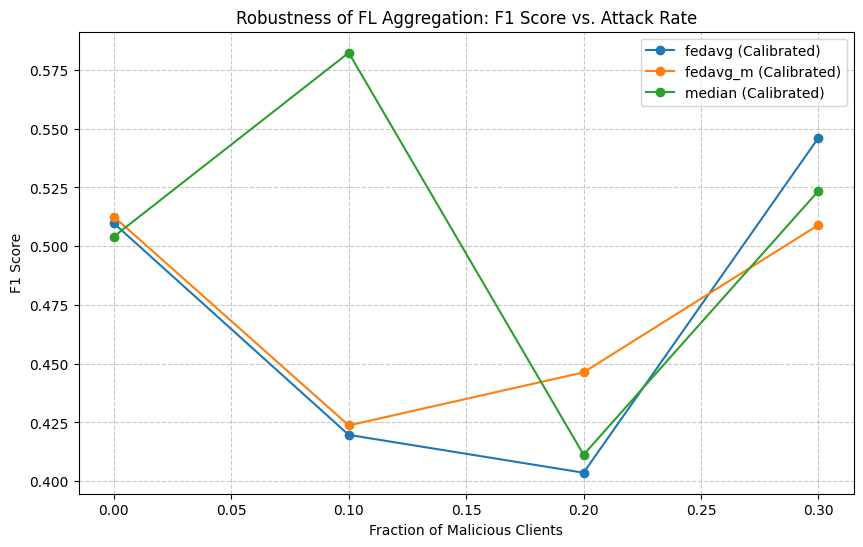

In [5]:
import numpy as np
import pandas as pd
import copy
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# %% [1] CONFIGURATION
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = "../data/processed/cicids_10pct_pruned.csv"
NUM_CLIENTS = 10
ALPHA = 0.1             # Strong Non-IID
ROUNDS = 20
SERVER_LR = 0.8         # For FedAvgM
ATTACK_RATES = [0.0, 0.1, 0.2, 0.3]

# %% [2] DATA LOADING & PRE-FL SPLITTING
df = pd.read_csv(DATA_PATH)
df["target"] = (df["Label"] != "BENIGN").astype(int)

train_files = ["Monday-WorkingHours.pcap_ISCX.csv", "Tuesday-WorkingHours.pcap_ISCX.csv",
               "Wednesday-workingHours.pcap_ISCX.csv", "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
               "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"]
test_files = ["Friday-WorkingHours-Morning.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
              "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"]

df_train_raw = df[df["source_file"].isin(train_files)].copy()
df_test_raw  = df[df["source_file"].isin(test_files)].copy()

META_COLS = ["Label", "label_bin", "label_binary", "source_file", "day", "attack_group", "target"]
X_train_all = df_train_raw.drop(columns=META_COLS).select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
y_train_all = df_train_raw["target"]
X_test_all  = df_test_raw.drop(columns=META_COLS).select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
y_test = df_test_raw["target"]

# Validation set for threshold calibration
X_train_pool, X_val_raw, y_train_pool, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.15, random_state=RANDOM_STATE, stratify=y_train_all
)

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

X_train_scaled = pipeline.fit_transform(X_train_pool)
X_val          = pipeline.transform(X_val_raw)
X_test         = pipeline.transform(X_test_all)

# %% [3] HELPER FUNCTIONS
def split_clients_dirichlet(X, y, num_clients, alpha=0.1):
    num_classes = len(np.unique(y))
    class_indices = {c: np.where(y == c)[0] for c in range(num_classes)}
    client_indices = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        np.random.shuffle(class_indices[c])
        proportions = np.random.dirichlet(alpha * np.ones(num_clients))
        proportions = (np.cumsum(proportions) * len(class_indices[c])).astype(int)[:-1]
        splits = np.split(class_indices[c], proportions)
        for i in range(num_clients): client_indices[i].extend(splits[i])
    return [(X[idxs], y.iloc[idxs].values) for idxs in client_indices if len(idxs) > 0]

def apply_label_flipping(clients, malicious_indices):
    attacked = []
    for i, (X, y) in enumerate(clients):
        y_proc = (1 - y) if i in malicious_indices else y
        attacked.append((X, y_proc))
    return attacked

def aggregate_median(client_models):
    all_coefs = np.stack([m.coef_ for m in client_models])
    all_ints = np.stack([m.intercept_ for m in client_models])
    return np.median(all_coefs, axis=0), np.median(all_ints, axis=0)

def find_optimal_threshold(model, X_v, y_v):
    y_probs = model.predict_proba(X_v)[:, 1]
    best_f1, best_tau = 0, 0.5
    for tau in np.arange(0.05, 0.96, 0.01):
        f1 = f1_score(y_v, (y_probs >= tau).astype(int))
        if f1 > best_f1:
            best_f1, best_tau = f1, tau
    return best_tau

def init_model():
    return LogisticRegression(max_iter=10, solver="lbfgs", warm_start=True, class_weight='balanced', random_state=RANDOM_STATE)

def local_train(global_model, X_local, y_local):
    if len(np.unique(y_local)) < 2: return None
    model = copy.deepcopy(global_model)
    model.fit(X_local, y_local)
    return model

# %% [4] EXPERIMENT FUNCTION
def run_byzantine_experiment(malicious_fraction):
    clients_list = split_clients_dirichlet(X_train_scaled, y_train_pool, NUM_CLIENTS, alpha=ALPHA)
    
    # Select malicious indices
    n_malicious = int(malicious_fraction * len(clients_list))
    if n_malicious > 0:
        mal_idx = np.random.choice(len(clients_list), n_malicious, replace=False)
    else:
        mal_idx = []
    
    poisoned_clients = apply_label_flipping(clients_list, mal_idx)
    exp_results = []

    for tech in ['fedavg', 'fedavg_m', 'median']:
        print(f"  Training {tech}...")
        global_model = init_model()
        # Warm start
        global_model.fit(X_train_scaled[:1000], y_train_pool.iloc[:1000])

        for _ in range(ROUNDS):
            c_models = [local_train(global_model, xc, yc) for xc, yc in poisoned_clients]
            c_models = [m for m in c_models if m is not None]

            if tech == 'fedavg':
                global_model.coef_ = np.mean(np.stack([m.coef_ for m in c_models]), axis=0)
                global_model.intercept_ = np.mean(np.stack([m.intercept_ for m in c_models]), axis=0)
            elif tech == 'fedavg_m':
                avg_c = np.mean(np.stack([m.coef_ for m in c_models]), axis=0)
                avg_i = np.mean(np.stack([m.intercept_ for m in c_models]), axis=0)
                global_model.coef_ = (1 - SERVER_LR) * global_model.coef_ + SERVER_LR * avg_c
                global_model.intercept_ = (1 - SERVER_LR) * global_model.intercept_ + SERVER_LR * avg_i
            elif tech == 'median':
                global_model.coef_, global_model.intercept_ = aggregate_median(c_models)

        # Calibration & Evaluation
        tau_star = find_optimal_threshold(global_model, X_val, y_val)
        y_probs_test = global_model.predict_proba(X_test)[:, 1]

        exp_results.append({
            "attack_rate": malicious_fraction,
            "method": tech,
            "AUC": roc_auc_score(y_test, y_probs_test),
            "F1_default": f1_score(y_test, (y_probs_test >= 0.5).astype(int)),
            "F1_calibrated": f1_score(y_test, (y_probs_test >= tau_star).astype(int)),
            "tau_star": tau_star
        })
    return exp_results

# %% [5] EXECUTION & SWEEP
all_results = []
for rate in ATTACK_RATES:
    print(f"\n=== Running attack rate: {int(rate*100)}% ===")
    all_results.extend(run_byzantine_experiment(rate))

results_df = pd.DataFrame(all_results)
print("\n--- Byzantine Attack Sweep Results ---")
print(results_df.to_string(index=False))

# %% [6] VISUALIZATION
plt.figure(figsize=(10, 6))
for method in results_df["method"].unique():
    subset = results_df[results_df["method"] == method]
    plt.plot(subset["attack_rate"], subset["F1_calibrated"], marker="o", label=f"{method} (Calibrated)")

plt.xlabel("Fraction of Malicious Clients")
plt.ylabel("F1 Score")
plt.title("Robustness of FL Aggregation: F1 Score vs. Attack Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()